In [ ]:
!pip install quadprog

**Course Name : CS6613 Artificial Intelligence**


**Project 2 :** Continual learning for robotic perception


**Author** : Harsh Thakkar (ht1215@nyu.edu)

Continual learning has become essential because real-world data keeps changing and we at any point never have access to the entire dataset from the data distribution. So at an instance, we try to train the model on given training dataset and expect it to perform well on future dataset as result is of course not desirable. When a model is trained on certain dataset, it acquires knowledge from that dataset in and stores in the form of weights and observing similar data it can predict the label or target value associated with this. When this same model observes the data from other distribution, it performs very poorly since stored weights have no idea about the new data distribution. When try to train the same model on new data, all the weights are over-written, that is it gains new knowledge based on new dataset and perform well on new dataset at the cost of performing poorly on the old dataset. This concept is known as "Catastrophic forgetting". 

Continual learning is an approach to human-like thinking. An effort to carry forward previously learned knowledge while learning new tasks. In this notebook, I tried to discuss one of the methods, Gradient episodic memory, discussed in the paper : http://papers.nips.cc/paper/7225-gradient-episodic-memory-for-continual-learning.pdf




**Approach** 

Instead of taking batches from the same dataset, in this approach, we take batches from different tasks and instead of training it with (x,y) where x is the feature vector and y is the label, we take (x,t,y) where t is the task number and train the model using this data distribution. While updating the data distribution in this way, there are many unknown challanges that were not present in the prior method. 

1) Non-IID dataset : Since data continuum in this method depends on the task number, entire data distribution changes when the task number changes.

2) Catastrophic forgetting : Learning new tasks overwrites the previously learned weights.

3) Transfer learning : When the tasks are related to each other, there is a possibility of transferring previous knowledge to the current tasks for faster learning.


**FRAMEWORK**

The idea is to feed (x,t) where x is the feature vector and t is the task descriptor and try to predict target vector y. Using of task descriptor is essential since, there is a possibility that in one task a feature vector x corresponds to a vector y and in other task same feature vector corresponds to different target vector. 

Other than accuracy of the system, it is also important to note the amount of knowledge being transferred to the future tasks and affect of learning new tasks on previous learned tasks. 

1) Backward transfer : That is the effect of learning current task on previously learned tasks. Positive backward transfer measures how much accuracy of previously learned tasks have been improved because of learning new task and negative backward transfer measures the degradation of performance of previous tasks because of learning new task. 

2) Forward Transfer : This measures the effect of learning current tasks on future tasks

To measure the above mentioned parameters, after learning each tasks t, model is evaluated its test performance on all the T tasks. A matrix is created (R) in which for any entry i,j is the test accuracy of j task after learning i task.



This cell loads MNIST dataset from the source and stores in the working dictionary

In [ ]:
import numpy as np
import subprocess
import pickle
import torch
import os

mnist_path = "mnist.npz"

if not os.path.exists(mnist_path):
    subprocess.call("wget https://s3.amazonaws.com/img-datasets/mnist.npz", shell=True)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print("Loading MNIST Dataset......")
f = np.load('mnist.npz')
    
x_train = torch.from_numpy(f['x_train'])
y_train = torch.from_numpy(f['y_train']).long()
x_test = torch.from_numpy(f['x_test'])
y_test = torch.from_numpy(f['y_test']).long()

f.close()

torch.save((x_train, y_train), 'mnist_train.pt')
torch.save((x_test, y_test), 'mnist_test.pt')
print("Loading Finished")

Loading MNIST Dataset......
Loading Finished


This cell takes input from MNIST dataset and rotate each image and stores in a seperate data file for future use. Random angle is selected from the range and rotate each image with given angle and stores in the file in format (angle, x_data, y_data). Considering we focus on 20 different set of images that is 20 tasks. Therefore for a single task, all the 60k images from training set and all the 10k images from test set are rotated to an angle and stored correspoing to that task.

In [ ]:
from torchvision import transforms
from PIL import Image
import argparse
import os.path
import random

torch.manual_seed(0)

tasks_tr = []
tasks_te = []

x_tr, y_tr = torch.load(os.path.join('mnist_train.pt'))
x_te, y_te = torch.load(os.path.join('mnist_test.pt'))

num_tasks = 20
min_angle = 0
max_angle = 180

def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result


for t in range(num_tasks):
    min_rot = 1.0 * t / num_tasks * (max_angle - min_angle) + min_angle
    max_rot = 1.0 * (t + 1) / num_tasks * (max_angle - min_angle) + min_angle
    rot = random.random() * (max_rot - min_rot) + min_rot
    tasks_tr.append([rot, rotate_dataset(x_tr, rot), y_tr])
    tasks_te.append([rot, rotate_dataset(x_te, rot), y_te])
    print("Rotation angle : " ,rot)

torch.save([tasks_tr, tasks_te], 'mnist_rotation.pt')


Rotation angle :  0.8907694362773108
Rotation angle :  9.296451270586154
Rotation angle :  18.75783163925422
Rotation angle :  27.56881547567297
Rotation angle :  43.377329291612504
Rotation angle :  48.57667303018247
Rotation angle :  58.450121163627266
Rotation angle :  68.26619119933564
Rotation angle :  76.76213652334327
Rotation angle :  86.89617310027629
Rotation angle :  91.02546422598101
Rotation angle :  103.84053417517347
Rotation angle :  112.37376115794072
Rotation angle :  119.5483390566128
Rotation angle :  132.24448438633794
Rotation angle :  135.9533383218581
Rotation angle :  147.81704046175864
Rotation angle :  153.4463945876474
Rotation angle :  162.91302168813965
Rotation angle :  174.92692642576398


This cell takes input from MNIST dataset and permutes images and stores in the seperate file mnist_permutation.pt in the formate (random_permutation, x_data, y_data). Again for this dataset also, number of tasks are taken as 20. 

In [ ]:

tasks_tr = []
tasks_te = []

num_tasks = 20

print("Permutation of MNIST...")
x_tr, y_tr = torch.load(os.path.join('mnist_train.pt'))
x_te, y_te = torch.load(os.path.join('mnist_test.pt'))
x_tr = x_tr.float().view(x_tr.size(0), -1) / 255.0
x_te = x_te.float().view(x_te.size(0), -1) / 255.0
y_tr = y_tr.view(-1).long()
y_te = y_te.view(-1).long()

for t in range(num_tasks):
    p = torch.randperm(x_tr.size(1)).long().view(-1)

    tasks_tr.append(['random permutation', x_tr.index_select(1, p), y_tr])
    tasks_te.append(['random permutation', x_te.index_select(1, p), y_te])

torch.save([tasks_tr, tasks_te], 'mnist_permutation.pt')
print("File saved")

Permutation of MNIST...
File saved


This cell loads mnist_rotation and mnist_permutation dataset and stores in the variable training, testing, input, output, tasks. 

In [ ]:
def load_datasets(inputfile):
    d_tr, d_te = torch.load(inputfile)
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

rot_train, rot_test, rot_n_inputs, rot_n_outputs, rot_n_tasks = load_datasets('mnist_rotation.pt')
per_train, per_test, per_n_inputs, per_n_outputs, per_n_tasks = load_datasets('mnist_permutation.pt')

Continuum class is used to generate continuous data stream. Varibale samples_per_task controls switching between the tasks after samples are taken. 

rot_train => Rotated training dataset

rot_test => Rotated testing dataset

per_train => Permuted training dataset

per_test => Permuted testing dataset

rot_n_inputs = per_n_inputs => 784 which is 28x28

rot_n_outputs = per_n_outputs => 10 which is 10

rot_n_tasks = per_n_tasks => 20

Continuum returns 10 images everytime when called and changes to next task when it crosses samples_per_task. After every 1000 images task descriptor changes.

In [ ]:
batch_size = 10
samples_per_task = 1000
n_epochs = 10
shuffle_tasks = "no"

class Continuum:

    def __init__(self, data):
        self.data = data
        self.batch_size = batch_size
        n_tasks = len(data)
        task_permutation = range(n_tasks)

        if shuffle_tasks == 'yes':
            task_permutation = torch.randperm(n_tasks).tolist()

        sample_permutations = []

        for t in range(n_tasks):
            N = data[t][1].size(0)
            if samples_per_task <= 0:
                n = N
            else:
                n = min(samples_per_task, N)
            p = torch.randperm(N)[0:n]
            sample_permutations.append(p)

        self.permutation = []

        for t in range(n_tasks):
            task_t = task_permutation[t]
            for _ in range(n_epochs):
                task_p = [[task_t, i] for i in sample_permutations[task_t]]
                random.shuffle(task_p)
                self.permutation += task_p

        self.length = len(self.permutation)
        self.current = 0

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.current >= self.length:
            raise StopIteration
        else:
            ti = self.permutation[self.current][0]
            j = []
            i = 0
            while (((self.current + i) < self.length) and
                   (self.permutation[self.current + i][0] == ti) and
                   (i < self.batch_size)):
                j.append(self.permutation[self.current + i][1])
                i += 1
            self.current += i
            j = torch.LongTensor(j)
            return self.data[ti][1][j], ti, self.data[ti][2][j]

This cell makes common layered network architecture for both single network and GEM network. 

In [ ]:
import math
import torch.nn as nn
from torch.nn.functional import relu, avg_pool2d

n_layers = 2
n_hiddens = 100

def fun(m):
    if m.__class__.__name__ == 'Linear':
        fan_in, fan_out = m.weight.data.size(1), m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0.0)


class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.net.apply(fun)

    def forward(self, x):
        return self.net(x)

This cell defines the structure of Simple network for classification.
Given number of inputs, number of outputs and total tasks. For a given task, this model learns the weights associated for that task and predicts well on the same task test data but training on different tasks it overwrites the previously learned weights.

In [ ]:
learning_simple = 0.3
class SimpleNet(torch.nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks):
        super(SimpleNet, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])
        self.opt = torch.optim.SGD(self.parameters(), lr=learning_simple)
        self.bce = torch.nn.CrossEntropyLoss()
        self.nc_per_task = n_outputs
        
    def compute_offsets(self, task):
        offset1 = 0
        offset2 = self.n_outputs
        return int(offset1), int(offset2)

    def forward(self, x, t):
        output = self.net(x)
        return output

    def observe(self, x, t, y):
        self.train()
        self.zero_grad()
        self.bce(self(x, t), y).backward()
        self.opt.step()
    


This cell represents gradient episodic memory algorithm described in the paper : http://papers.nips.cc/paper/7225-gradient-episodic-memory-for-continual-learning.pdf

When observing new task, it is first checked whether this task is new task then the previous one or not. 2 tensors are kept to store data and labels assigned. Memory counter is kept to track the next position to store new data and when this counter reaches to the maximum meory, it starts overwrites from the beginning. 

When the new tasks come, algorithm first goes through all the previous learned tasks and calculates the gradients and stores them for future calculations. 
Then it learns new task and calculate gradients. Idea is to keep the loss on the current task less while keeping in mind that the sum of losses on previous tasks using this model should be less then sum of losses on previous tasks using previous best model. If this condition violates, it calculates projection of the new gradients on each of the previously leanred gradients and overwrites. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import quadprog

def compute_offsets(task, nc_per_task):
    offset1 = 0
    offset2 = nc_per_task
    return offset1, offset2

def store_grad(pp, grads, grad_dims, tid):
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1

def overwrite_grad(pp, newgrad, grad_dims):
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1

def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

n_layers = 2
n_hiddens = 100
memory_strength = 0.5
learning_rate = 0.1
n_memories = 256
isCuda = 'yes'

class GEMNet(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks):
        super(GEMNet, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.margin = memory_strength
        self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])
        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs
        self.opt = optim.SGD(self.parameters(), learning_rate)
        self.n_memories = n_memories
        self.gpu = isCuda
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if isCuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if isCuda:
            self.grads = self.grads.cuda()
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        self.nc_per_task = n_outputs

    def forward(self, x, t):
        output = self.net(x)
        return output

    def observe(self, x, t, y):
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                past_task = self.observed_tasks[tt]

                offset1, offset2 = compute_offsets(past_task, self.nc_per_task)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task)
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()
        if len(self.observed_tasks) > 1:
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()


Life-Experience : This function takes input as continuum, model and test dataset as input and trains the model. When the task changes, eval_tasks function is called to measure performance fluctuations in all tasks because of the update and measures accuracy on all the tasks and stores in the results. 

In [ ]:
def eval_tasks(model, tasks):
    model.eval()
    result = []
    for i, task in enumerate(tasks):
        t = i
        x = task[1]
        y = task[2]
        rt = 0
        
        eval_bs = x.size(0)

        for b_from in range(0, x.size(0), eval_bs):
            b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            if isCuda:
                xb = xb.cuda()
            _, pb = torch.max(model(xb, t).data.cpu(), 1, keepdim=False)
            rt += (pb == yb).float().sum()

        result.append(rt / x.size(0))

    return result

log_every = 100
def life_experience(model, continuum, x_te):
    result_a = []
    result_t = []

    current_task = 0
    time_start = time.time()

    for (i, (x, t, y)) in enumerate(continuum):
        if(((i % log_every) == 0) or (t != current_task)):
            result_a.append(eval_tasks(model, x_te))
            result_t.append(current_task)
            current_task = t

        v_x = x.view(x.size(0), -1)
        v_y = y.long()

        if isCuda:
            v_x = v_x.cuda()
            v_y = v_y.cuda()

        model.train()
        model.observe(v_x, t, v_y)

    result_a.append(eval_tasks(model, x_te))
    result_t.append(current_task)

    time_end = time.time()
    time_spent = time_end - time_start

    return torch.Tensor(result_t), torch.Tensor(result_a), time_spent


After getting information on accuracy fluctuations because of training new tasks, confusion matrix measures 4 important quantities from the matrix. 

1) Average accuracy : As it can be seen when a task is trained on the model, it will perform well on the same task test data but poor on other task test data. So taking average of all the diagonal elements will give the average accuracy of the model on the same task when it is trained on it.

2) Final accuracy : This represents the accuracy of the model on all the test tasks after learning all the tasks. Higher the average final value, better continual model it is. 
 
3) BWT (Backward transfer) : Performance change on previous tasks when the model finishes training on all tasks, that is R[T, t]- R[t,t]

4) FWT (Forward trasnfer) : Performance change on future tasks after learning the current task. 

In [ ]:
def task_changes(result_t):
    n_tasks = int(result_t.max() + 1)
    changes = []
    current = result_t[0]
    for i, t in enumerate(result_t):
        if t != current:
            changes.append(i)
            current = t

    return n_tasks, changes


def confusion_matrix(result_t, result_a, fname=None):
    nt, changes = task_changes(result_t)

    baseline = result_a[0]
    changes = torch.LongTensor(changes + [result_a.size(0)]) - 1
    result = result_a[changes]

    # acc[t] equals result[t,t]
    acc = result.diag()
    fin = result[nt - 1]
    # bwt[t] equals result[T,t] - acc[t]
    bwt = result[nt - 1] - acc

    # fwt[t] equals result[t-1,t] - baseline[t]
    fwt = torch.zeros(nt)
    for t in range(1, nt):
        fwt[t] = result[t - 1, t] - baseline[t]

    if fname is not None:
        f = open(fname, 'w')

        print(' '.join(['%.4f' % r for r in baseline]), file=f)
        print('|', file=f)
        for row in range(result.size(0)):
            print(' '.join(['%.4f' % r for r in result[row]]), file=f)
        print('', file=f)
        # print('Diagonal Accuracy: %.4f' % acc.mean(), file=f)
        print('Final Accuracy: %.4f' % fin.mean(), file=f)
        print('Backward: %.4f' % bwt.mean(), file=f)
        print('Forward:  %.4f' % fwt.mean(), file=f)
        f.close()

    stats = []
    stats.append(acc.mean())
    stats.append(fin.mean())
    stats.append(bwt.mean())
    stats.append(fwt.mean())

    return stats


Continuum defination, model declaration, model training and parameter calculation for all the 4 tasks on 2 models. 

In [ ]:
import time
rot_continuum = Continuum(rot_train)

rot_simple_model = SimpleNet(rot_n_inputs, rot_n_outputs, rot_n_tasks)
rot_simple_model.cuda()

rot_simple_result_t, rot_simple_result_a, rot_simple_spent_time = life_experience(rot_simple_model, rot_continuum, rot_test)
rot_simple_stats = confusion_matrix(rot_simple_result_t, rot_simple_result_a)

In [ ]:
per_continuum = Continuum(per_train)

per_simple_model = SimpleNet(per_n_inputs, per_n_outputs, per_n_tasks)
per_simple_model.cuda()

per_simple_result_t, per_simple_result_a, per_simple_spent_time = life_experience(per_simple_model, per_continuum, per_test)
per_simple_stats = confusion_matrix(rot_simple_result_t, rot_simple_result_a)

In [ ]:
rot_continuum = Continuum(rot_train)

rot_gem_model = GEMNet(rot_n_inputs, rot_n_outputs, rot_n_tasks)
rot_gem_model.cuda()

rot_gem_result_t, rot_gem_result_a, rot_gem_spent_time = life_experience(rot_gem_model, rot_continuum, rot_test)
rot_gem_stats = confusion_matrix(rot_gem_result_t, rot_gem_result_a)

In [ ]:
per_continuum = Continuum(per_train)

per_gem_model = GEMNet(per_n_inputs, per_n_outputs, per_n_tasks)
per_gem_model.cuda()

per_gem_result_t, per_gem_result_a, per_gem_spent_time = life_experience(per_gem_model, per_continuum, per_test)
per_gem_stats = confusion_matrix(per_gem_result_t, per_gem_result_a)

Observation of the parameters : Where values are

Average accuracy, Final accuracy, Backward trasnfer, Forward trasnfer respectively

In [ ]:
print(rot_simple_stats)
print(rot_gem_stats)
print(per_simple_stats)
print(per_gem_stats)


[tensor(0.9001), tensor(0.3665), tensor(-0.5336), tensor(0.7087)]
[tensor(0.9070), tensor(0.8857), tensor(-0.0213), tensor(0.7311)]
[tensor(0.9001), tensor(0.3665), tensor(-0.5336), tensor(0.7087)]
[tensor(0.8930), tensor(0.8459), tensor(-0.0471), tensor(0.0022)]


Below graphs show the performance improvement by using Gradient episodic memory algorithm. First bar represents accuracy of simple model and second bar represents of GEM model. 

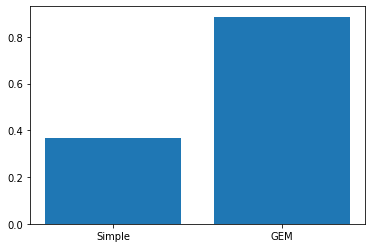

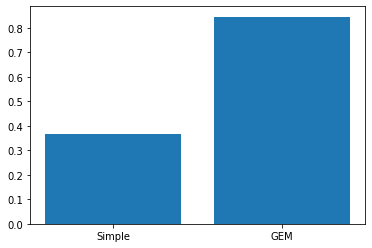

In [ ]:
import matplotlib.pyplot as plt

rot_final_accuracy = []
per_final_accuracy = []
dataset = ['Simple', 'GEM']
y_pos = np.arange(len(dataset))

rot_final_accuracy.append(rot_simple_stats[1])
rot_final_accuracy.append(rot_gem_stats[1])

per_final_accuracy.append(per_simple_stats[1])
per_final_accuracy.append(per_gem_stats[1])


plt.figure()
plt.bar(y_pos, rot_final_accuracy)
plt.xticks(y_pos, dataset)
plt.show()


plt.figure()
plt.bar(y_pos, per_final_accuracy)
plt.xticks(y_pos, dataset)
plt.show()
